#### Для корректной работы нужно
* переместить файлы test.csv & train.csv в директорию data/
* скачать [graphviz](http://www.graphviz.org/download)  
* вылетает ошибка [“dot.exe” not found in path](https://stackoverflow.com/questions/40632486/dot-exe-not-found-in-path-pydot-on-python-windows-7)

In [1]:
import pandas as pd
import sys
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler  
from sklearn.model_selection import cross_val_score 

In [2]:
train = pd.read_csv('data/train.csv')
train.head(50)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200189 entries, 0 to 200188
Data columns (total 36 columns):
loan_amnt                     200189 non-null float64
term                          200189 non-null object
int_rate                      200189 non-null float64
installment                   200189 non-null float64
grade                         200189 non-null object
sub_grade                     200189 non-null object
emp_title                     189062 non-null object
emp_length                    192135 non-null object
home_ownership                200189 non-null object
annual_inc                    200189 non-null float64
verification_status           200189 non-null object
issue_d                       200189 non-null object
loan_status                   200189 non-null int64
pymnt_plan                    200189 non-null object
purpose                       200189 non-null object
zip_code                      200189 non-null object
addr_state                    200189 n

* int_rate - Interest Rate on the loan
* annual_inc - Theannual income provided by the borrower during registration
* inq_last_6mths -The number of inquiries in past 6 months (excluding auto and mortgage inquiries)
* mths_since_last_delinq  - Months since most recent personal finance delinquency.
* pub_rec  - Number of derogatory public records
* revolBal - Total credit revolving balance
* revolUtil - Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.


## Линейная регрессия

In [2]:
from sklearn import linear_model

In [50]:
y = train[train['int_rate'] >= 0]['int_rate'] # целевой признак
x = train.loc[:,['annual_inc','inq_last_6mths','mths_since_last_delinq','pub_rec','revol_bal','revol_util','loan_status','tot_coll_amt'] ] # параметры
x['mths_since_last_delinq'] = x['mths_since_last_delinq'].fillna(0)
x['revol_util'] = x['revol_util'].fillna(0)
x['tot_coll_amt'] = x['tot_coll_amt'].fillna(0)

In [104]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 42)
lm = linear_model.Lasso(alpha=0.01,random_state = 42)
model = lm.fit(x_train, y_train)
pred_test = lm.predict(x_test)
accuracies = cross_val_score(estimator = lm, X=x_train, y=y_train, cv=5)  

In [108]:
print("MSE for test sample: %.2f"
      % mean_squared_error(y_test,lm.predict(x_test)))
print("MSE for train sample: %.2f"
      % mean_squared_error(y_train, lm.predict(x_train)))
print('R2 for test sample: %.2f' % r2_score(y_test, lm.predict(x_test)))
print('R2 for train sample: %.2f' % r2_score(y_train,lm.predict(x_train)))

MSE for test sample: 15.12
MSE for train sample: 15.09
R2 for test sample: 0.23
R2 for train sample: 0.23


## Логическая регрессия

In [109]:
y = train['loan_status'] # целевой признак
x = train.loc[:,['annual_inc','inq_last_6mths`','mths_since_last_delinq','pub_rec','revol_bal','revol_util','loan_status','tot_coll_amt'] ] # параметры
x['mths_since_last_delinq'] = x['mths_since_last_delinq'].fillna(0)
x['revol_util'] = x['revol_util'].fillna(0)
x['tot_coll_amt'] = x['tot_coll_amt'].fillna(0)

In [1]:
# lr = linear_model.LogisticRegression()
# lr.fit(x_train, y_train)

## Дерево решений

In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from IPython.display import Image
from sklearn.externals.six import StringIO
import pydot
import os
os.environ["PATH"] += os.pathsep + 'D:/graphviz-2.38/release/bin'


In [35]:
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

In [106]:
y = train['loan_status'] # целевой признак
x = train.loc[:,['annual_inc','int_rate','pub_rec'] ] # параметры

In [107]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 42)
clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)
clf_tree.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

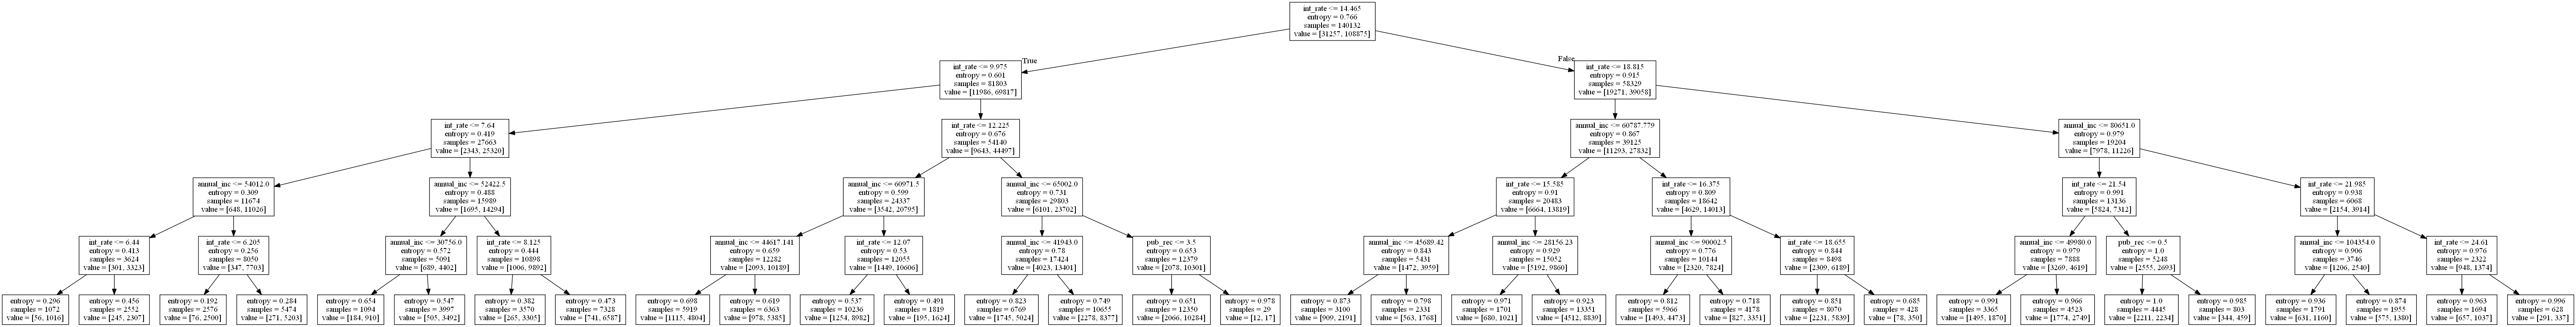

In [108]:
dot_data = StringIO()  
export_graphviz(clf_tree, out_file=dot_data, feature_names=['annual_inc','int_rate','pub_rec'] )  
(graph,) = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png()) 

##  Метод ближайших соседей